# **Final Project: Organized Script**

This Google Collab serves as our final step-by-step script for the Final Project.

# Web Scraping

In [ ]:
# RUN THIS FIRST

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.Yf2dnr5ZeR/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.i51EkkAs1v/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.laTo9fr638/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian bust

In [ ]:
# WEBSCRAPING https://www.dormy.ph/

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import requests
import time
import pandas as pd

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--remote-debugging-port=9222")

webdriver_service = Service('/usr/bin/chromedriver')
driver = webdriver.Chrome(service=webdriver_service, options=chrome_options)

driver.get('https://www.dormy.ph/find/featured-rentals')

previous_height = driver.execute_script('return document.body.scrollHeight')

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(10)
    new_height = driver.execute_script('return document.body.scrollHeight')
    if new_height == previous_height:
        break
    previous_height = new_height

html_text = driver.page_source
soup = BeautifulSoup(html_text, 'lxml')

listings_data = []

listings_all = soup.find_all('a', class_='whf flex flex-col space-y-2 overflow-hidden group px-3 md:px-0 select-none')
base_url = 'https://www.dormy.ph'

for listing in listings_all:
    data = {}
    page_url = listing.get('href')
    concatenated_url = base_url + page_url

    listing_html_text = requests.get(concatenated_url).text
    listing_soup = BeautifulSoup(listing_html_text, 'lxml')

    listing_title_elem = listing_soup.find('h1', class_='font-bold text-[24px] leading-tight mb-1')
    data['Title'] = listing_title_elem.text.strip() if listing_title_elem else 'N/A'

    listing_location_elem = listing_soup.find('p', class_='leading-tight text-sm')
    data['Location'] = listing_location_elem.text.strip() if listing_location_elem else 'N/A'

    listing_price_elem = listing_soup.find('p', class_='font-bold text-[24px] leading-none')
    data['Price'] = listing_price_elem.text.strip() if listing_price_elem else 'N/A'

    # Extracting features
    features_elements = listing_soup.find_all('div', class_='flex items-center capitalize')
    data['Features'] = [elem.find('p').text.strip() for elem in features_elements if elem.find('p')]

    # Extracting amenities
    amenities_elements = listing_soup.find_all('div', class_='flex flex-row items-center flex-nowrap space-x-2')
    data['Amenities'] = [elem.find('p', class_='flex items-center pr-1').text.strip() for elem in amenities_elements if elem.find('p', class_='flex items-center pr-1')]

    # Extracting payment terms
    payment_terms_elements = listing_soup.find_all('div', class_='flex flex-row items-center')
    payment_terms = []
    for elem in payment_terms_elements:
        term_p = elem.find('p', class_='flex items-center pr-1')
        term_span = elem.find('p', class_='font-semibold')
        if term_p and term_span:
            payment_terms.append(f"{term_p.text.strip()}: {term_span.text.strip()}")
    data['Payment_Terms'] = payment_terms

    listings_data.append(data)

driver.quit()

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(listings_data, columns=['Title', 'Location', 'Price', 'Features', 'Amenities', 'Payment_Terms'])

# Print the DataFrame
print(df)

df.to_csv('dormy_listings.csv', index=False)

*Note: Issues from the Dormy Website might have occurred, as new listings from the site were added. To check the working output of our web scraping, kindly proceed to the Documentation Script under Final Web Scraping.*

# Data Cleaning


In [ ]:
#RUN THIS FIRST

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Initial Cleaning**

In [ ]:
# Loading Dataset
file_path = '/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/dormy_listings.csv'
df = pd.read_csv(file_path)

## Data Cleaning
# Replace '[]' with NaN
df.replace('[]', pd.NA, inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Replace 'N/A' with NaN and drop rows with NaN values
df.replace('N/A', pd.NA, inplace=True)
df.dropna(inplace=True)

# Drop rows with 'null' values
df.replace('null', pd.NA, inplace=True)
df.dropna(inplace=True)

# Generate the cleaned version of the dataset
df.to_csv('cleaned_data.csv', index=False)

print(df)

                                                 Title  \
0    LEVINA PLACE PASIG ORTIGAS for rent PET FRIEND...   
1                Bedspace for rent in Green Residences   
4    STUDIOUNIT FOR RENT IN MANILA NEAR MAKATI,MAND...   
5    Fully-Furnished Studio Condo & Parking Slot in...   
6    Male Condo Sharing at Urban Deca Homes Ortigas...   
..                                                 ...   
322                                      CONDO AT TAFT   
323                                      CONDO AT TAFT   
324         Condo for Rent in Ubelt, Manila, Pedro Gil   
325                Condo for Rent near UP Manila, DLSU   
326   Condo for Rent in Manila near Adamson University   

                                              Location              Price  \
0       Rosario , Pasig, National Capital Region (NCR)     â‚±143 monthly   
1    Barangay 725, Manila, National Capital Region ...   â‚±8,000 monthly   
4    Barangay 792, Santa Ana, National Capital Regi...  â‚±12,000 monthl

**Separating Features and Payment Terms into Subsections**

In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/cleaned_data.csv'
df = pd.read_csv(file_path)

# Split the 'Features' column by comma
df_features_split = df['Features'].str.split(',', expand=True)
df_features_split.columns = ['Furnishing Status', 'Property Type', 'Size', 'Room Type', 'Bathroom Type', 'Gender Accommodation']

# Split the 'Payment_Terms' column by '::'
df_payment_terms_split = df['Payment_Terms'].str.split(',', expand=True)
df_payment_terms_split.columns = ['Payment Term 1', 'Payment Term 2', 'Payment Term 3', 'Payment Term 4', 'Payment Term 5', 'Payment Term 6','Payment Term 7','Payment Term 8','Payment Term 9']

# Combine the original DataFrame with the new separated columns
df_final = pd.concat([df, df_features_split, df_payment_terms_split], axis=1).drop(columns=['Features', 'Payment_Terms'])

# Save the DataFrame to a CSV file
output_filename = 'separated_features_and_payment_terms.csv'
df_final.to_csv(output_filename, index=False)

print(df_final)
print(f"Final DataFrame saved to {output_filename}.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                                 Title  \
0    LEVINA PLACE PASIG ORTIGAS for rent PET FRIEND...   
1                Bedspace for rent in Green Residences   
2    STUDIOUNIT FOR RENT IN MANILA NEAR MAKATI,MAND...   
3    Fully-Furnished Studio Condo & Parking Slot in...   
4    Male Condo Sharing at Urban Deca Homes Ortigas...   
..                                                 ...   
244                                      CONDO AT TAFT   
245                                      CONDO AT TAFT   
246         Condo for Rent in Ubelt, Manila, Pedro Gil   
247                Condo for Rent near UP Manila, DLSU   
248   Condo for Rent in Manila near Adamson University   

                                              Location            Price  \
0       Rosario , Pasig, National Capital Region (NCR)     ₱143 monthly   
1    Barangay 725, Manil

**Polishing Duplicates and Inconsistent Variables**

In [ ]:
import pandas as pd

# Loading Dataset
cleaned_df = pd.read_csv('/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_cleaned_data (2).csv')

# Basic information about the Data Frame
info = cleaned_df.info()
summary_statistics = cleaned_df.describe()
categorical_summary = {col: cleaned_df[col].value_counts() for col in cleaned_df.select_dtypes(include='object').columns}

# Display the results
print("Basic Information:\n")
print(info)

print("\nSummary Statistics for Numerical Columns:\n")
print(summary_statistics)

print("\nValue Counts for Categorical Columns:\n")
for col, value_counts in categorical_summary.items():
    print(f"{col}:\n{value_counts}\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Title                            200 non-null    object
 1   Location                         200 non-null    object
 2   City                             200 non-null    object
 3   Listing ID                       200 non-null    int64 
 4   City ID                          200 non-null    int64 
 5   Price (paid monthly)             200 non-null    int64 
 6   Aircon                           200 non-null    int64 
 7   Commercial Spaces                200 non-null    int64 
 8   Community Area                   200 non-null    int64 
 9   Elevator                         200 non-null    int64 
 10  Fitness Gym                      200 non-null    int64 
 11  Meeting Room                     200 non-null    int64 
 12  Parking                          200

**Data Frame Presentation**

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_cleaned_data (2).csv')
print(df.head())
print(df.info())

                                               Title  \
0  FOR RENT: The Grove SEMI-FURNISHED STUDIO UNIT ‼️   
1                                2 Bedroom Apartment   
2  Studio Condo For Rent In Manila Near Makati an...   
3              Bedspace for rent in Green Residences   
4  Fully-Furnished Studio Condo & Parking Slot in...   

                                            Location           City  \
0        Ugong, Pasig, National Capital Region (NCR)  City of Pasig   
1  Brgy. 755, Santa Ana, Manila, National Capital...         Manila   
2  Barangay 792, Santa Ana, National Capital Regi...         Manila   
3  Barangay 725, Manila, National Capital Region ...         Manila   
4  South Triangle, Quezon City, National Capital ...    Quezon City   

   Listing ID  City ID  Price (paid monthly)  Aircon  Commercial Spaces  \
0           1        8                 23000       1                  1   
1           2       10                 19500       0                  0   
2          

In [ ]:
print("Column names:")
print(df.columns)

print("\nFirst few rows of the data:")
print(df.head())

print("\nData types of columns:")
print(df.dtypes)

Column names:
Index(['Title', 'Location', 'City', 'Listing ID', 'City ID',
       'Price (paid monthly)', 'Aircon', 'Commercial Spaces', 'Community Area',
       'Elevator', 'Fitness Gym', 'Meeting Room', 'Parking',
       'Recreational Area', 'Roof Deck', 'Study Hub', 'Swimming Pool',
       'Wifi / Internet', 'Chapel Room', 'Refrigerator', 'Kitchen', 'KTV Room',
       'Music Room', 'Printer', 'Bare/Unfurnished', 'Semi-Furnished',
       'Studio,1; Bedroom,0', 'Size', 'Private, 1; Shared, 0: Room',
       'Private, 1; Shared, 0: Bathroom', 'Male Only', 'Female Only',
       'Post-dated Cheques', 'Electricity Bills', 'Water Bills',
       'Association Dues'],
      dtype='object')

First few rows of the data:
                                               Title  \
0  FOR RENT: The Grove SEMI-FURNISHED STUDIO UNIT ‼️   
1                                2 Bedroom Apartment   
2  Studio Condo For Rent In Manila Near Makati an...   
3              Bedspace for rent in Green Residences   


# Data Preprocessing

**Transforming Categorical Variables into Binary Matrix**

In [ ]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# File path to the original CSV file
file_path = '/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/onehot.csv'
df = pd.read_csv(file_path)

# Process amenities column separately for one-hot encoding
amenities_expanded = df['Amenities'].str.get_dummies(sep=', ')

# One-hot encode other categorical columns
df_encoded = pd.get_dummies(df.drop(columns=['Amenities']), # Features and Amenities were already separated into subsections beforehand
                            columns=['City', 'Furnishing Status', 'Property Type', 'Room Type',
                                     'Bathroom Type', 'Gender Accommodation', 'Post-Dated Cheques',
                                     'Electricity Bills', 'Water Bills', 'Association Dues'],
                            dtype=int)

# Concatenate the one-hot encoded amenities with the other encoded columns
df_encoded = pd.concat([df_encoded, amenities_expanded], axis=1)

# Display the first few rows
print(df_encoded.head())

# Save to a new CSV file
new_file_path = '/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_encoded_onehot.csv'
df_encoded.to_csv(new_file_path, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                               Title  Listing ID  City ID  \
0  FOR RENT: The Grove SEMI-FURNISHED STUDIO UNIT ‼️         1.0      8.0   
1                                2 Bedroom Apartment         2.0     10.0   
2  Studio Condo For Rent In Manila Near Makati an...         3.0     10.0   
3              Bedspace for rent in Green Residences         4.0     10.0   
4  Fully-Furnished Studio Condo & Parking Slot in...         5.0     12.0   

             Price     Size  Unnamed: 12  City_City of Bacoor  \
0  ₱23,000 monthly  34 sqm.          NaN                    0   
1  ₱19,500 monthly  60 sqm.          NaN                    0   
2  ₱12,000 monthly  25 sqm.          NaN                    0   
3   ₱8,000 monthly  23 sqm.          NaN                    0   
4  ₱18,000 monthly  23 sqm.          NaN                    0   

   City_City of D

# Exploration Data Analysis (EDA)

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_cleaned_data (2).csv')

# Check the column names
print(df.columns)

Index(['Title', 'Location', 'City', 'Listing ID', 'City ID',
       'Price (paid monthly)', 'Aircon', 'Commercial Spaces', 'Community Area',
       'Elevator', 'Fitness Gym', 'Meeting Room', 'Parking',
       'Recreational Area', 'Roof Deck', 'Study Hub', 'Swimming Pool',
       'Wifi / Internet', 'Chapel Room', 'Refrigerator', 'Kitchen', 'KTV Room',
       'Music Room', 'Printer', 'Bare/Unfurnished', 'Semi-Furnished',
       'Studio,1; Bedroom,0', 'Size', 'Private, 1; Shared, 0: Room',
       'Private, 1; Shared, 0: Bathroom', 'Male Only', 'Female Only',
       'Post-dated Cheques', 'Electricity Bills', 'Water Bills',
       'Association Dues'],
      dtype='object')


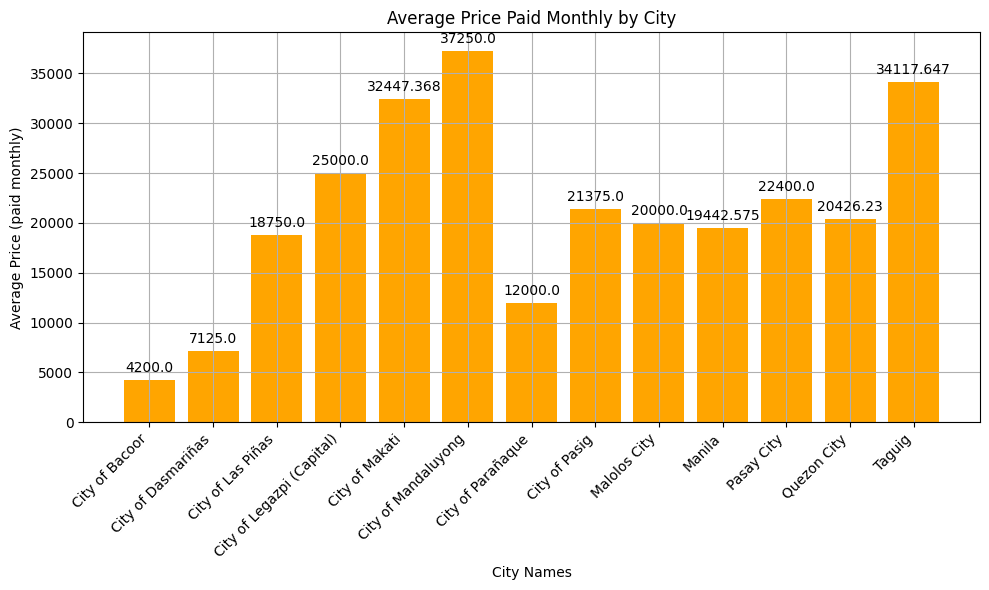

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Load the CSV file
cleaned_df = '/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_cleaned_data (2).csv'

# Group by 'City' and calculate the average price
average_prices = df.groupby('City')['Price (paid monthly)'].mean().reset_index()

# Plot the graph
plt.figure(figsize=(10, 6))
bars = plt.bar(average_prices['City'], average_prices['Price (paid monthly)'], color='orange')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, round(yval, 3), ha='center', va='bottom')

plt.xlabel('City Names')
plt.ylabel('Average Price (paid monthly)')
plt.title('Average Price Paid Monthly by City')
plt.xticks(rotation=45, ha='right')
plt.grid(True)

plt.tight_layout()
plt.show()


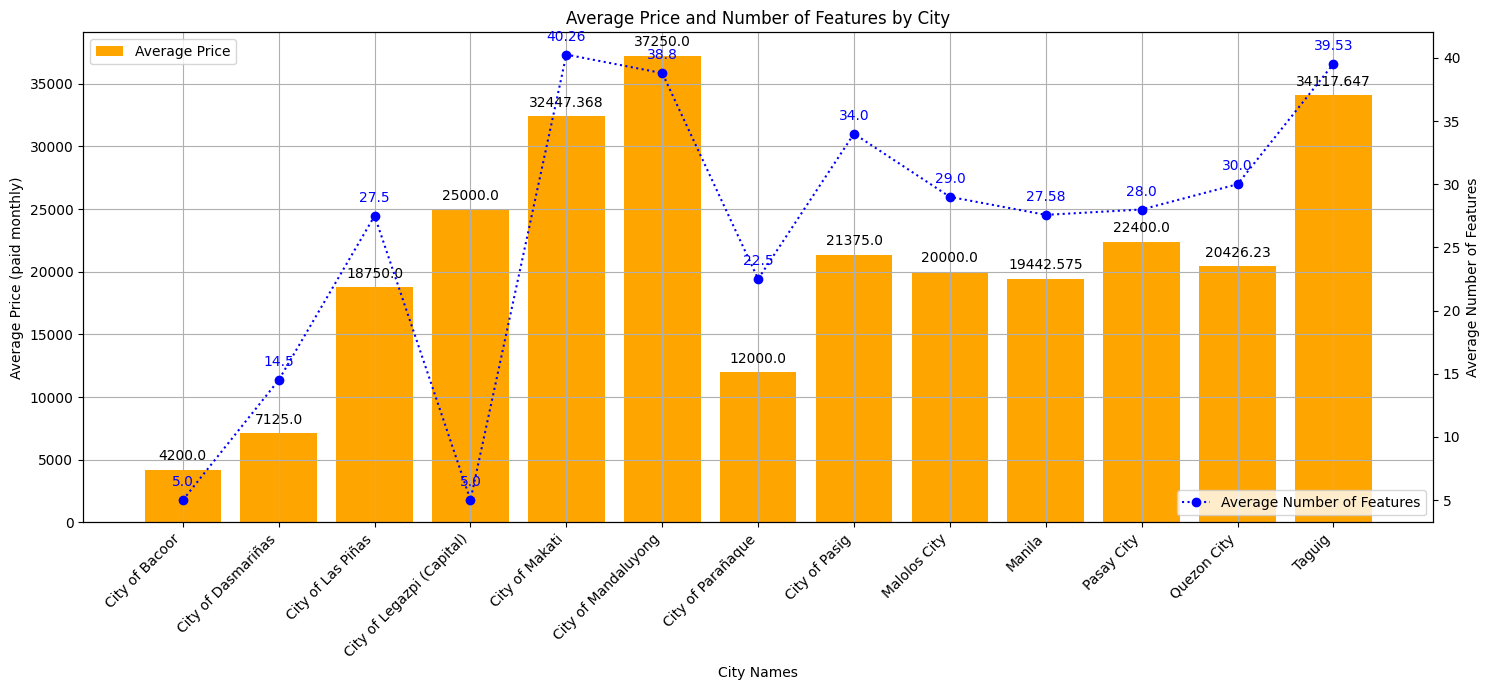

In [ ]:
#with average price and average features
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/content/drive/Shareddrives/Group 4 - DATAPRE/DATAPRE Group 4/final_cleaned_data (2).csv')
average_prices = df.groupby('City')['Price (paid monthly)'].mean().reset_index()

#merge the features into one
features_columns = [
    'Bare/Unfurnished', 'Semi-Furnished', 'Studio,1; Bedroom,0', 'Size',
    'Private, 1; Shared, 0: Room', 'Private, 1; Shared, 0: Bathroom',
    'Male Only', 'Female Only', 'Post-dated Cheques', 'Electricity Bills',
    'Water Bills', 'Association Dues'
]

# Calculate the total number of features per city (averaging binary values)
df['Total Features'] = df[features_columns].sum(axis=1)
features_counts = df.groupby('City')['Total Features'].mean().reset_index()
combined_df = pd.merge(average_prices, features_counts, on='City')

# Plotting the results
fig, ax1 = plt.subplots(figsize=(15, 7))

# Bar plot for average prices
bars = ax1.bar(combined_df['City'], combined_df['Price (paid monthly)'], color='orange', label='Average Price')
ax1.set_xlabel('City Names')
ax1.set_ylabel('Average Price (paid monthly)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 500, round(yval, 3), ha='center', va='bottom', color='black')

# Line plot for features
ax2 = ax1.twinx()
ax2.plot(combined_df['City'], combined_df['Total Features'], color='blue', marker='o', linestyle=':', label='Average Number of Features')
ax2.set_ylabel('Average Number of Features', color='black')
ax2.tick_params(axis='y', labelcolor='black')

for i, txt in enumerate(combined_df['Total Features']):
    ax2.annotate(round(txt, 2), (combined_df['City'][i], combined_df['Total Features'][i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

plt.title('Average Price and Number of Features by City')

ax1.set_xticks(combined_df['City'])
ax1.set_xticklabels(combined_df['City'], rotation=45, ha='right')
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()